In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Giải nén file .zip
!unzip "/content/drive/MyDrive/Dataset2.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Dataset2/Train/Covid/covid_2687.png  
  inflating: /content/data/__MACOSX/Dataset2/Train/Covid/._covid_2687.png  
  inflating: /content/data/Dataset2/Train/Covid/covid_4584.png  
  inflating: /content/data/__MACOSX/Dataset2/Train/Covid/._covid_4584.png  
  inflating: /content/data/Dataset2/Train/Covid/covid_611.png  
  inflating: /content/data/__MACOSX/Dataset2/Train/Covid/._covid_611.png  
  inflating: /content/data/Dataset2/Train/Covid/covid_2863.png  
  inflating: /content/data/__MACOSX/Dataset2/Train/Covid/._covid_2863.png  
  inflating: /content/data/Dataset2/Train/Covid/covid_2877.png  
  inflating: /content/data/__MACOSX/Dataset2/Train/Covid/._covid_2877.png  
  inflating: /content/data/Dataset2/Train/Covid/sub-S09832_ses-E19533_run-1_bp-chest_vp-ap_dx.png  
  inflating: /content/data/__MACOSX/Dataset2/Train/Covid/._sub-S09832_ses-E19533_run-1_bp-chest_vp-ap_dx.png  
  inflating: /content/data/Dataset2

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
from torchvision.transforms import InterpolationMode
import torch

seed = 252
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# 1. Chuẩn hóa & augmentation

# ===== CLAHE Transform =====
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        # Chuyển PIL → numpy
        if isinstance(img, Image.Image):
            img = np.array(img)

        # Đảm bảo ảnh là grayscale (1 kênh)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Áp dụng CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img = clahe.apply(img)

        # numpy → PIL để torchvision xử lý tiếp
        return Image.fromarray(img)

class PerImageStandardization(object):
    def __call__(self, tensor):
        # Tính mean và std của riêng bức ảnh đó
        mean = torch.mean(tensor)
        std = torch.std(tensor)

        # Tránh chia cho 0
        if std == 0:
            return tensor

        # Công thức Z-score: (X - mean) / std
        return (tensor - mean) / std

# ===== Train Transform =====
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((256, 256)),                    #Resize to 256x256
    transforms.RandomRotation(degrees=15, fill=0),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=0),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),                            # Convert to tensor
    PerImageStandardization()
])


# ===== Validation / Test Transform =====
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    PerImageStandardization()
])

# 2. Load dataset từ thư mục
train_data = datasets.ImageFolder(root="data/Dataset2/Train", transform=train_transform)
val_data   = datasets.ImageFolder(root="data/Dataset2/Val", transform=val_transform)
test_data  = datasets.ImageFolder(root="data/Dataset2/Test", transform=val_transform)

# 3. DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
# 4. Kiểm tra
print("Số ảnh train:", len(train_data))
print("Số ảnh val:", len(val_data))
print("Số ảnh test:", len(test_data))
print("Các class:", classes)
print("Số class:", len(classes))

Số ảnh train: 9783
Số ảnh val: 1506
Số ảnh test: 3762
Các class: ['Covid', 'Non-Covid', 'Normal']
Số class: 3


In [ ]:
import torch
import torch.nn as nn

class XRayCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(XRayCNN, self).__init__()

        # ---- 1. Convolutional Blocks ----
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )

        # ---- 2. Fully Connected Layers ----
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # sau 4 lần pooling: 256→128→64→32→16
        self.fc2 = nn.Linear(512, num_classes)
        self.leaky_relu = nn.LeakyReLU(0.01)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        output_class = outputs.argmax(dim=1)
        correct += (output_class == labels).sum().item()
        total += labels.size(0)

    acc = correct / total * 100
    return train_loss / len(dataloader), acc

In [ ]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device):
    model.eval()
    val_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            output_class = outputs.argmax(dim=1)
            correct += (output_class == labels).sum().item()
            total += labels.size(0)

    acc = correct / total * 100
    return val_loss / len(dataloader), acc

In [ ]:
import torch
import torch.optim as optim

# --- Khai báo thiết bị ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XRayCNN(num_classes=3).to(device)

# --- Optimizer và Scheduler ---
optimizer = optim.Adam(model.parameters(), lr=0.00005)


# --- Loss function ---
criterion = nn.CrossEntropyLoss()

In [ ]:
import time

seed = 252
torch.manual_seed(seed)         # PyTorch CPU seed
torch.cuda.manual_seed(seed)    # PyTorch GPU seed (nếu có GPU)

# --- Tham số huấn luyện ---
num_epochs = 70

# --- Lưu lại lịch sử để vẽ biểu đồ ---
train_losses, val_losses, train_accs, val_accs = [], [], [], []

print("Bắt đầu huấn luyện mô hình ...")
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    # --- Train ---
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)

    # --- Validation ---
    val_loss, val_acc = val_step(model, val_loader, criterion, device)

    # --- Lưu lại kết quả ---
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    epoch_time = time.time() - epoch_start  # thời gian 1 epoch

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% || "
          f"Time: {epoch_time:.2f}s")

total_time = time.time() - start_time
print(f"Huấn luyện hoàn tất trong {total_time/60:.2f} phút. Mô hình tốt nhất lưu tại: best_model2.pth")
torch.save(model.state_dict(), "best_model2basic2.pth")

Bắt đầu huấn luyện mô hình ...
Epoch [1/70] | Train Loss: 0.9665, Train Acc: 51.65% || Val Loss: 0.8406, Val Acc: 61.89% || Time: 72.77s
Epoch [2/70] | Train Loss: 0.8355, Train Acc: 62.37% || Val Loss: 0.7852, Val Acc: 65.54% || Time: 72.08s
Epoch [3/70] | Train Loss: 0.7598, Train Acc: 67.02% || Val Loss: 0.7067, Val Acc: 70.45% || Time: 73.28s
Epoch [4/70] | Train Loss: 0.7041, Train Acc: 69.84% || Val Loss: 0.6410, Val Acc: 74.44% || Time: 71.93s
Epoch [5/70] | Train Loss: 0.6595, Train Acc: 72.20% || Val Loss: 0.6041, Val Acc: 76.76% || Time: 73.07s
Epoch [6/70] | Train Loss: 0.6259, Train Acc: 74.02% || Val Loss: 0.5816, Val Acc: 77.95% || Time: 71.87s
Epoch [7/70] | Train Loss: 0.5773, Train Acc: 76.31% || Val Loss: 0.6180, Val Acc: 76.03% || Time: 73.06s
Epoch [8/70] | Train Loss: 0.5599, Train Acc: 77.30% || Val Loss: 0.6179, Val Acc: 76.76% || Time: 72.28s
Epoch [9/70] | Train Loss: 0.5402, Train Acc: 77.92% || Val Loss: 0.4850, Val Acc: 81.41% || Time: 73.04s
Epoch [10/70] |

In [ ]:
# 5. Test Evaluation
start_time = time.time()
test_loss, test_acc = val_step(model=model,
                               dataloader=test_loader,
                               loss_fn=criterion,
                               device=device)
end_time = time.time()
test_time = end_time - start_time
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}% | Test time: {test_time:.2f}s")

Test loss: 0.2581 | Test acc: 91.31% | Test time: 15.10s


In [ ]:
# Copy file model sang Google Drive
!cp best_model2.pth /content/drive/MyDrive/

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def plot_confusion_matrix(model, dataloader, classes, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Tạo confusion matrix (đếm số lượng)
    cm = confusion_matrix(all_labels, all_preds)

    # Vẽ heatmap với số lượng ảnh
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",  # fmt="d" để hiển thị số nguyên
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix (Counts)")
    plt.show()

    # In thêm classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

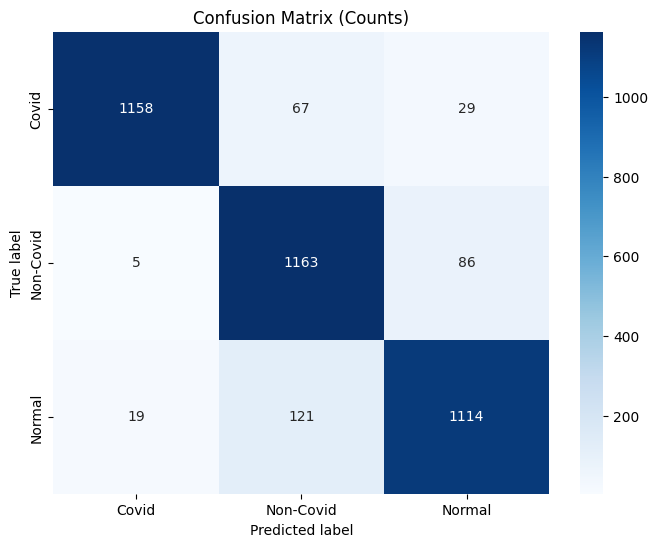


Classification Report:

              precision    recall  f1-score   support

       Covid       0.98      0.92      0.95      1254
   Non-Covid       0.86      0.93      0.89      1254
      Normal       0.91      0.89      0.90      1254

    accuracy                           0.91      3762
   macro avg       0.92      0.91      0.91      3762
weighted avg       0.92      0.91      0.91      3762



In [ ]:
# Vẽ confusion matrix trên tập test
plot_confusion_matrix(model, test_loader, classes, device)

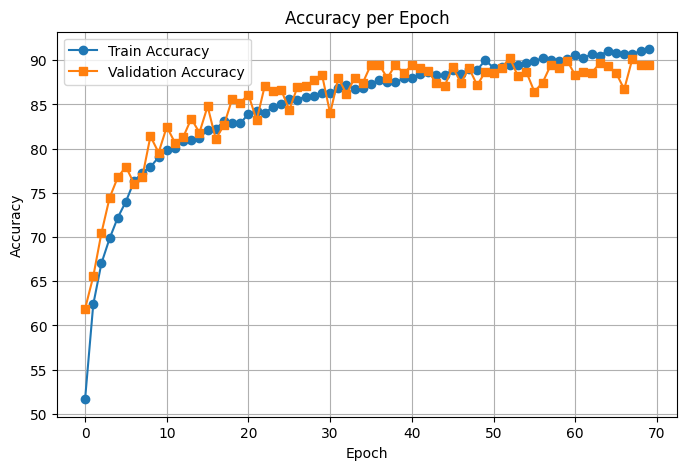

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='s')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()